In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
import pandas as pd
from pickle import load

from sklearn.metrics import roc_auc_score

In [2]:
loadAndPlot = False
#loadAndPlot = True

In [3]:
def seed_everything(seed=0):
    #random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #tf keras
seed_everything(0)

# Configure tunable params

In [4]:
#cmapp = plt.get_cmap("RdYlBu")

plotDir = "plots/"

batch_size = 4*1024

#nBins of NN Score histogram
nBins = 30

# mu values to scan
mu_values = np.arange(0,50)/10

In [5]:
clfCol = "b"; aweCol = "g"; augCol = "y"; invCol = "r"; clfNomCol = "k"

## z_syst list (reduced list to run faster)

In [6]:
z_syst_plot =  np.sort(np.concatenate([np.array([0.8, 0.84]), np.arange(88,115)/100]))
z_syst = z_syst_plot

systUp = 1.1
systDown = 0.8
z_nominal = 1.

# Load Dataset

In [7]:
try:
    # Python 2
    xrange
except NameError:
    # Python 3, xrange is now named range
    xrange = range

In [8]:
# train-test split done according to event number

# load the scaler
scaler = load(open('HiggsModels/scaler.pkl', 'rb'))

def loadSystData(z_val):
    from util import train_test_split_evtNo
    from dataLoc import dataLoc
    fileName = dataLoc +"HiggsML_TES_{}.h5".format(z_val)
    print ("Loading file: ",fileName)
    
    data = pd.read_hdf(fileName, "data_syst")
    data = data.sample(frac=1).reset_index(drop=False) #shuffle the events
    target = data["Label"]
    weights = data["Weight"]
    Z = data["Z"]
    evtNo = data["index"]
    del data["Label"]
    del data["Z"]
    del data["Weight"]
    del data["index"]


    data = data.values
    target = target.values
    weights = weights.values
    Z = Z.values
    evtNo = evtNo.values
    
    assert (Z == Z[0]).all() # files contain only 1 z
    
        
    X_syst_train, X_syst_test, Y_syst_train, Y_syst_test, Z_syst_train, Z_syst_test, weights_train, weights_test  = train_test_split_evtNo(
        data, target, Z, weights,evtNo=evtNo,n=3)

    del X_syst_train, Y_syst_train, Z_syst_train, weights_train
    
    ## load the scaler
    X_syst_test = scaler.transform(X_syst_test)
    
    class_weights = weights[target == 0].sum(), weights[target == 1].sum()

    class_weights_test = weights_test[Y_syst_test == 0].sum(), weights_test[Y_syst_test == 1].sum(), weights_test[Y_syst_test == 2].sum()
    scale_up = 1.
    for i in xrange(2):
        weights_test[Y_syst_test == i] *= class_weights[i]/class_weights_test[i]
        
    del data, target, weights, Z
    
    return X_syst_test, Y_syst_test, Z_syst_test, weights_test



# Load Clf Model

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [10]:
if not loadAndPlot:
    from tensorflow import keras

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages

In [11]:
if not loadAndPlot:
    nominal_model = keras.models.load_model("HiggsModels/clf.h5")

# Load Data Augmented Model

In [12]:
aug_NN = True
if not loadAndPlot:
    augmented_model = keras.models.load_model("HiggsModels/aug.h5")

# Load Up/Down Model

In [13]:
if not loadAndPlot:
    down_model = keras.models.load_model("HiggsModels/down_model.h5")

In [14]:
if not loadAndPlot:
    up_model = keras.models.load_model("HiggsModels/up_model.h5")

# Load Syst Aware Model

In [15]:
if not loadAndPlot:
    aware_model = keras.models.load_model("HiggsModels/AwareModel.h5")

# Load Pivot

In [16]:
if not loadAndPlot:
    inv_model = keras.models.load_model('HiggsModels/invariant_model.h5')

#  Likelihood Fits

In [17]:
z_std = 0.05

In [18]:
mu_test = 1.
#mu_test = 2.

In [19]:
def nll_stat(N,S,B,mu):
    from scipy.special import loggamma
    nexp=mu*S+B
    nll_stat = - (N* np.log(nexp) - nexp - loggamma(N) ) # Poisson
    if np.isinf(nll_stat):
        print (N, nexp)
    return nll_stat

def nll_syst(dTheta, sigma=1):
    nll_syst = - (np.log (1/(sigma*np.sqrt(2*np.pi))) + (-0.5 * (dTheta/sigma)**2))
    return nll_syst

# Build 2D histograms of NLL 

In [20]:
# Assumes each HDF file has events for one fixed z value

def buildTemplates(model, clfName,nBins=nBins):
    sig_hists = []
    back_hists = []
    for z_val in z_syst:
        X_syst_test, Y_syst_test, Z_syst_test, weights_test = loadSystData(z_val)
        zEvents = np.array([True] * len(Z_syst_test)) # for legacy reasons
        if (clfName == "Aware"):
            print ("Not Currently Supported for analyticial aware classifier")
            Y_pred_model = model.predict(x=[X_syst_test,Z_syst_test], batch_size=batch_size).reshape(-1)
        elif (clfName == "Nominal") or (clfName == "Augmented") or (clfName == "Invariant") or (clfName == "Down") or (clfName == "Up") :
            if (clfName == "Augmented") and (not aug_NN):
                Y_pred_model = model.predict_proba(X_syst_test)[:,1].reshape(-1)
            else:
                Y_pred_model = model.predict(X_syst_test, batch_size=batch_size).reshape(-1)
        else:
            print ("Unexpected Clf name!!")
            
        hist_sig, bin_array = np.histogram(
            Y_pred_model[zEvents &(Y_syst_test==1)], 
            weights=weights_test[zEvents &(Y_syst_test==1)], range=(0,1), bins=nBins)
        hist_back, bin_array = np.histogram(
            Y_pred_model[zEvents &(Y_syst_test==0)], 
            weights=weights_test[zEvents &(Y_syst_test==0)], range=(0,1), bins=nBins)
            
        sig_hists.append(hist_sig)
        back_hists.append(hist_back)
        
    del X_syst_test, Y_syst_test, Z_syst_test, weights_test
    
    sig_hists = np.array(sig_hists)
    back_hists = np.array(back_hists)
    return sig_hists, back_hists

In [21]:
def plotNLLCurves(x, y_list, label_list, color_list, linestyle_list, testDataLabel,
                  ylimRatio=[0.8, 1.2], xlim=[0.5,1.5], legendOrder=None):
    # assumes last y is reference
    ref_y = y_list[-1]
    
    fig = plt.figure(figsize=(5, 5)) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 
    gs.update(wspace=0.025, hspace=0.025)
    ax0 = plt.subplot(gs[0])
    plt.ylabel(r'NLL - min(NLL)', fontsize=15)
    
    for (y, lab, col, ls) in zip(y_list, label_list, color_list, linestyle_list):
        ax0.plot(x,y, label=lab, color=col, linestyle=ls)
    ax0.set_ylim([-0.08, 2])
    ax0.set_xlim(xlim)
    if (legendOrder is None):
        plt.legend(prop={'size': 15}, loc="lower right")
    else:
        handles, labels = ax0.get_legend_handles_labels()
        # re-order and legend in one step
        ax0.legend([handles[i] for i in legendOrder], [labels[i] for i in legendOrder],
                  prop={'size': 14.1}, loc=(-0.175,1.04), handletextpad=0.1, borderpad=0.1,
                  handlelength=1, ncol=2 ) 
    
    ax1 = plt.subplot(gs[1], sharex = ax0) # sharing not working
    for (y, lab, col, ls) in zip(y_list, label_list, color_list, linestyle_list):
        ratio_y = y/ref_y
        ax1.plot(x[~np.isnan(ratio_y)],ratio_y[~np.isnan(ratio_y)], label=lab, color=col, linestyle=ls)
    ax1.set_ylim(ylimRatio)
    ax1.set_xlim(xlim)
    plt.xlabel(r'$\mu$', fontsize=20)
    plt.ylabel(r'ratio', fontsize=15)
    plt.tight_layout()

## Usual Classifier (trained on Nominal only)

In [22]:
if not loadAndPlot:
    sig_hists, back_hists = buildTemplates(model=nominal_model, clfName="Nominal")

Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.8.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.84.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.88.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.89.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.9.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.91.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.92.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.93.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.94.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.95.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.96.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.97.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.98.h5
Loading file:  /data1/users/aishik/systc

In [23]:
X_syst_test_nominal, Y_syst_test_nominal, Z_syst_test_nominal, weights_test_nominal = loadSystData(z_val=z_nominal)
nominalEvents = np.array([True] * len(Z_syst_test_nominal)) # for legacy reasons

#del Y_syst_test_nominal, Z_syst_test_nominal
del Z_syst_test_nominal

Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_1.0.h5


In [24]:
def createHistObs(X, Y_true, weights, mu, model,):
    weights[Y_true==1] *= mu 
    Y_pred = model.predict(X, batch_size=batch_size).reshape(-1)
    hist_obs, bin_array = np.histogram(Y_pred, weights=weights, range=(0,1), bins=nBins)
    return hist_obs, bin_array

In [25]:
if not loadAndPlot:
      hist_obs, bin_array = createHistObs(X=X_syst_test_nominal[nominalEvents],
                                          Y_true=Y_syst_test_nominal[nominalEvents],
                                          weights=weights_test_nominal[nominalEvents], mu=mu_test,
                                          model=nominal_model, 
                                          )

In [ ]:
sig_hists = np.load("HiggsModels/ClfSignalTemplates.npy")
back_hists = np.load("HiggsModels/ClfBackgroundTemplates.npy")
hist_obs = np.load("HiggsModels/hist_obs.npy")

In [26]:
def computeNLL2D(obs1D, sH2d, bH2d, mu_values=mu_values):
    min_mu, min_z, minnll = 999,999,999
    assert len(obs1D) == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])    
    for i, z_val in enumerate(z_syst):
        for k,mu in enumerate(mu_values):
            nll2D[k][i] += nll_syst(dTheta=z_val-z_nominal, sigma=z_std)
            for n,s,b in zip(obs1D, sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    print ("Min at mu,z: ",min_mu, min_z)
    return nll2D

In [27]:
nll2D_clf_nom = computeNLL2D(obs1D=hist_obs, sH2d=sig_hists, bH2d=back_hists)

Min at mu,z:  1.0 1.0


In [28]:
def plot2dNLL(nll2D, dataName, clfName):
    xx, yy = np.meshgrid(mu_values,z_syst)
    ind = np.unravel_index(np.argmin(nll2D, axis=None), nll2D.shape)
    plt.pcolormesh(xx,yy,(nll2D-nll2D.min() + 1).T)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.set_ylabel(r"NLL - min(NLL) + 1", labelpad=5, size=20) 
    cbar.formatter.set_powerlimits((0, 0))
    plt.scatter(mu_values[ind[0]],z_syst[ind[1]] , color="crimson", s=200)
    plt.xlabel(r"$\mu$", size=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel(r"$z$", size=25)
    plt.tight_layout()

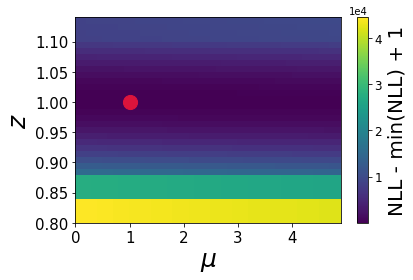

In [29]:
plot2dNLL(nll2D=nll2D_clf_nom, dataName="Nominal", clfName="Clf")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Clf", "Nominal",), bbox_inches='tight',pad_inches = 0)
plt.show()

In [32]:
nll1D_clf_nom = nll2D_clf_nom.min(axis=1)

In [31]:
X_syst_test_systUp, Y_syst_test_systUp, Z_syst_test_systUp, weights_test_systUp = loadSystData(z_val=systUp)
systUpEvents = np.array([True] * len(Z_syst_test_systUp)) # for legacy reasons

del Z_syst_test_systUp

X_syst_test_systDown, Y_syst_test_systDown, Z_syst_test_systDown, weights_test_systDown = loadSystData(z_val=systDown)
systDownEvents = np.array([True] * len(Z_syst_test_systDown)) # for legacy reasons

del Z_syst_test_systDown

Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_1.1.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.8.h5


In [33]:
if not loadAndPlot:
    hist_obs_systUp, bin_array = createHistObs(X=X_syst_test_systUp[systUpEvents],
                                               Y_true=Y_syst_test_systUp[systUpEvents],
                                               weights=weights_test_systUp[systUpEvents], mu=mu_test,
                                               model=nominal_model)
    hist_obs_systDown, bin_array = createHistObs(X=X_syst_test_systDown[systDownEvents],
                                                 Y_true=Y_syst_test_systDown[systDownEvents],
                                                 weights=weights_test_systDown[systDownEvents], mu=mu_test,
              model=nominal_model)

In [34]:
if 'bin_array' in globals():
    print("exists")
else:
    assert nBins==30
    bin_array = np.array([0.        , 0.03333334, 0.06666667, 0.1       , 0.13333334,
       0.16666667, 0.2       , 0.23333333, 0.26666668, 0.3       ,
       0.33333334, 0.36666667, 0.4       , 0.43333334, 0.46666667,
       0.5       , 0.53333336, 0.56666666, 0.6       , 0.6333333 ,
       0.6666667 , 0.7       , 0.73333335, 0.76666665, 0.8       ,
       0.8333333 , 0.8666667 , 0.9       , 0.93333334, 0.96666664,
       1.        ])

exists


In [ ]:
hist_obs_systUp = np.load("HiggsModels/hist_obs_systUp.npy")
hist_obs_systDown = np.load("HiggsModels/hist_obs_systDown.npy")

In [35]:
nll2D_clf_systUp = computeNLL2D(obs1D=hist_obs_systUp, sH2d=sig_hists, bH2d=back_hists)
nll2D_clf_systDown = computeNLL2D(obs1D=hist_obs_systDown, sH2d=sig_hists, bH2d=back_hists)

Min at mu,z:  1.0 1.1
Min at mu,z:  1.0 0.8


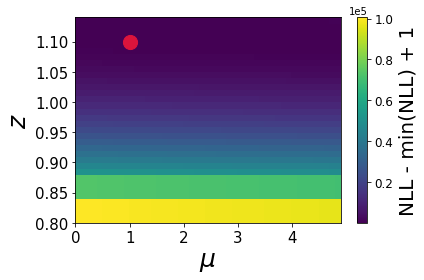

In [36]:
plot2dNLL(nll2D=nll2D_clf_systUp, dataName="SystUp", clfName="Clf")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Clf", "SystUp",), bbox_inches='tight',pad_inches = 0)
plt.show()

In [37]:
nll1D_clf_systUp = nll2D_clf_systUp.min(axis=1)
nll1D_clf_systDown = nll2D_clf_systDown.min(axis=1)

## Data Augmentation trained clf

In [39]:
if not loadAndPlot:
    sig_hists_aug, back_hists_aug = buildTemplates(model=augmented_model, clfName="Augmented")

Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.8.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.84.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.88.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.89.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.9.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.91.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.92.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.93.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.94.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.95.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.96.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.97.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.98.h5
Loading file:  /data1/users/aishik/systc

In [40]:
# hist_obs_aug, bin_array = np.histogram(
#     augmented_model.predict(X_syst_test_nominal[nominalEvents], batch_size=batch_size).reshape(-1), 
#     weights=weights_test_nominal[nominalEvents], range=(0,1), bins=nBins)

if not loadAndPlot:
    hist_obs_aug, bin_array = createHistObs(X=X_syst_test_nominal[nominalEvents],
                                            Y_true=Y_syst_test_nominal[nominalEvents],
                                            weights=weights_test_nominal[nominalEvents], 
                                            mu=mu_test,
              model=augmented_model)

In [ ]:
sig_hists_aug = np.load("HiggsModels/AugSignalTemplates.npy", )
back_hists_aug = np.load("HiggsModels/AugBackgroundTemplates.npy", )
hist_obs_aug = np.load("HiggsModels/hist_obs_Aug.npy", )

In [41]:
nll2D_aug_nom = computeNLL2D(obs1D=hist_obs_aug, sH2d=sig_hists_aug, bH2d=back_hists_aug)

Min at mu,z:  1.0 1.0


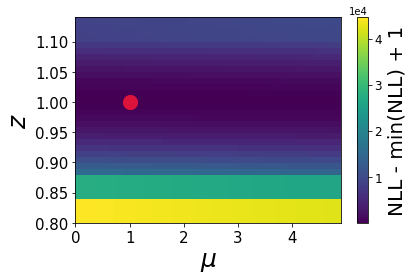

In [42]:
plot2dNLL(nll2D=nll2D_aug_nom, dataName="Nominal", clfName="Aug")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Aug", "Nominal",))
plt.show()

In [43]:
nll1D_aug_nom = nll2D_aug_nom.min(axis=1)

In [44]:
if not loadAndPlot:
    hist_obs_aug_systUp, bin_array = createHistObs(X=X_syst_test_systUp[systUpEvents],
                                                   Y_true=Y_syst_test_systUp[systUpEvents],
                                                   weights=weights_test_systUp[systUpEvents], mu=mu_test,
              model=augmented_model)
    hist_obs_aug_systDown, bin_array = createHistObs(X=X_syst_test_systDown[systDownEvents],
                                                     Y_true=Y_syst_test_systDown[systDownEvents],
                                                     weights=weights_test_systDown[systDownEvents], 
              mu=mu_test, model=augmented_model)

In [ ]:
hist_obs_aug_systUp = np.load("HiggsModels/hist_obs_aug_systUp.npy", )
hist_obs_aug_systDown = np.load("HiggsModels/hist_obs_aug_systDown.npy", )

In [45]:
nll2D_aug_systUp = computeNLL2D(obs1D=hist_obs_aug_systUp, sH2d=sig_hists_aug, bH2d=back_hists_aug)
nll2D_aug_systDown = computeNLL2D(obs1D=hist_obs_aug_systDown, sH2d=sig_hists_aug, bH2d=back_hists_aug)

nll1D_aug_systUp = nll2D_aug_systUp.min(axis=1)
nll1D_aug_systDown = nll2D_aug_systDown.min(axis=1)

Min at mu,z:  1.0 1.1
Min at mu,z:  1.0 0.8


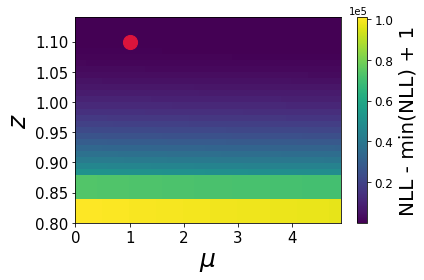

In [46]:
plot2dNLL(nll2D=nll2D_aug_systUp, dataName="SystUp", clfName="Aug")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Aug", "SystUp",))
plt.show()

## Clf trained on SystDown

In [47]:
if not loadAndPlot:
    sig_hists_down, back_hists_down = buildTemplates(model=down_model, clfName="Down")

Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.8.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.84.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.88.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.89.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.9.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.91.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.92.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.93.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.94.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.95.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.96.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.97.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.98.h5
Loading file:  /data1/users/aishik/systc

In [48]:
if not loadAndPlot:
    hist_obs_down, bin_array = createHistObs(X=X_syst_test_nominal[nominalEvents],
                                             Y_true=Y_syst_test_nominal[nominalEvents],
                                             weights=weights_test_nominal[nominalEvents], mu=mu_test,
              model=down_model)

In [ ]:
sig_hists_down = np.load("HiggsModels/DownSignalTemplates.npy", )
back_hists_down = np.load("HiggsModels/DownBackgroundTemplates.npy", )
hist_obs_down = np.load("HiggsModels/hist_obs_Down.npy", )

In [49]:
nll2D_down_nom = computeNLL2D(obs1D=hist_obs_down, sH2d=sig_hists_down, bH2d=back_hists_down)

Min at mu,z:  1.0 1.0


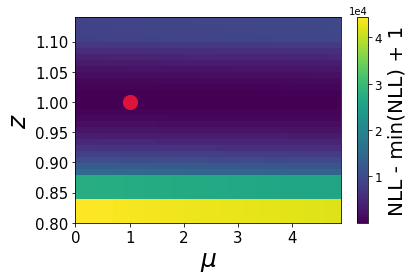

In [50]:
plot2dNLL(nll2D=nll2D_down_nom, dataName="Nominal", clfName="Down")
plt.show()

In [51]:
nll1D_down_nom = nll2D_down_nom.min(axis=1)

In [52]:
if not loadAndPlot:
    hist_obs_down_systUp, bin_array = createHistObs(X=X_syst_test_systUp[systUpEvents],
                                                    Y_true=Y_syst_test_systUp[systUpEvents],
                                                    weights=weights_test_systUp[systUpEvents], mu=mu_test,
              model=down_model)
    hist_obs_down_systDown, bin_array = createHistObs(X=X_syst_test_systDown[systDownEvents],
                                                      Y_true=Y_syst_test_systDown[systDownEvents],
                                                      weights=weights_test_systDown[systDownEvents], mu=mu_test,
              model=down_model)

In [ ]:
hist_obs_down_systUp = np.load("HiggsModels/hist_obs_down_systUp.npy", )
hist_obs_down_systDown = np.load("HiggsModels/hist_obs_down_systDown.npy", )

In [53]:
nll2D_down_systUp = computeNLL2D(obs1D=hist_obs_down_systUp, sH2d=sig_hists_down, bH2d=back_hists_down)
nll2D_down_systDown = computeNLL2D(obs1D=hist_obs_down_systDown, sH2d=sig_hists_down, bH2d=back_hists_down)

Min at mu,z:  1.0 1.1
Min at mu,z:  1.0 0.8


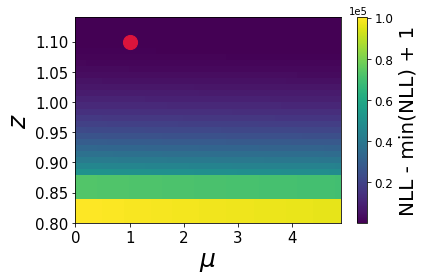

In [54]:
plot2dNLL(nll2D=nll2D_down_systUp, dataName="SystUp", clfName="Down")
plt.show()

In [55]:
nll1D_down_systUp = nll2D_down_systUp.min(axis=1)
nll1D_down_systDown = nll2D_down_systDown.min(axis=1)

## Clf trained on SystUp

In [56]:
if not loadAndPlot:
    sig_hists_up, back_hists_up = buildTemplates(model=up_model, clfName="Up")

Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.8.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.84.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.88.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.89.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.9.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.91.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.92.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.93.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.94.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.95.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.96.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.97.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.98.h5
Loading file:  /data1/users/aishik/systc

In [57]:
if not loadAndPlot:
    hist_obs_up, bin_array = createHistObs(X=X_syst_test_nominal[nominalEvents],
                                           Y_true=Y_syst_test_nominal[nominalEvents],
                                           weights=weights_test_nominal[nominalEvents], mu=mu_test,
              model=up_model)

In [ ]:
sig_hists_up = np.load("HiggsModels/UpSignalTemplates.npy", )
back_hists_up = np.load("HiggsModels/UpBackgroundTemplates.npy", )
hist_obs_up = np.load("HiggsModels/hist_obs_Up.npy", )

In [58]:
nll2D_up_nom = computeNLL2D(obs1D=hist_obs_up, sH2d=sig_hists_up, bH2d=back_hists_up)

Min at mu,z:  1.0 1.0


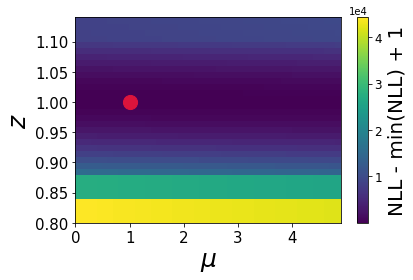

In [59]:
plot2dNLL(nll2D=nll2D_up_nom, dataName="Nominal", clfName="Up")
plt.show()

In [60]:
nll1D_up_nom = nll2D_up_nom.min(axis=1)

In [61]:
if not loadAndPlot:
    hist_obs_up_systUp, bin_array = createHistObs(X=X_syst_test_systUp[systUpEvents],
                                                  Y_true=Y_syst_test_systUp[systUpEvents],
                                                  weights=weights_test_systUp[systUpEvents], mu=mu_test, 
              model=up_model)

In [ ]:
hist_obs_up_systUp = np.load("HiggsModels/hist_obs_up_systUp.npy", )

In [62]:
nll2D_up_systUp = computeNLL2D(obs1D=hist_obs_up_systUp, sH2d=sig_hists_up, bH2d=back_hists_up)

Min at mu,z:  1.0 1.1


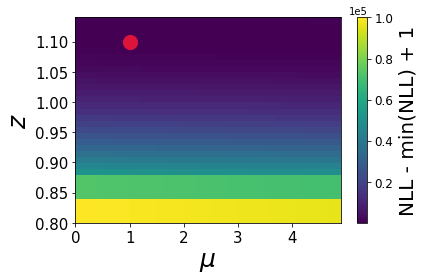

In [63]:
plot2dNLL(nll2D=nll2D_up_systUp, dataName="SystUp", clfName="Up")
plt.show()

In [64]:
nll1D_up_systUp = nll2D_up_systUp.min(axis=1)

## Syst Aware classifier

In [65]:
if not loadAndPlot:
    sig_hists_awe, back_hists_awe = buildTemplates(model=aware_model, clfName="Aware")

Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.8.h5
Not Currently Supported for analyticial aware classifier
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.84.h5
Not Currently Supported for analyticial aware classifier
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.88.h5
Not Currently Supported for analyticial aware classifier
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.89.h5
Not Currently Supported for analyticial aware classifier
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.9.h5
Not Currently Supported for analyticial aware classifier
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.91.h5
Not Currently Supported for analyticial aware classifier
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.92.h5
Not Currently Supported for analyticial aware classifier
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.93.h5
Not Current

In [66]:
def createHistObsAwe(X,Y_true, mu, weights):
    weights[Y_true==1] *= mu
    hist_obs_awe2D = []
    for hyp_z in z_syst:
        #FixMe calling predict multiple times is very slow, try doing it just once or JIT?
        Y = aware_model.predict([X, np.ones(X.shape[0]) * hyp_z], batch_size=batch_size).reshape(-1)
        hist_obs_awe, bin_array = np.histogram(Y, weights=weights, range=(0,1), bins=nBins)
        hist_obs_awe2D.append(hist_obs_awe)
    hist_obs_awe2D = np.array(hist_obs_awe2D)
    return hist_obs_awe2D

In [67]:
if not loadAndPlot:
    hist_obs_awe2D = createHistObsAwe(X=X_syst_test_nominal[nominalEvents],
                                      Y_true=Y_syst_test_nominal[nominalEvents],
                                      mu=mu_test,
                                      weights=weights_test_nominal[nominalEvents])

In [ ]:
sig_hists_awe = np.load("HiggsModels/AwareSignalTemplates.npy")
back_hists_awe = np.load("HiggsModels/AwareBackgroundTemplates.npy")
hist_obs_awe2D = np.load("HiggsModels/hist_obs_awe2D.npy")

In [68]:
def computeNLL2D_aware(obs2D, sH2d, bH2d, mu_values=mu_values):
    min_mu, min_z, minnll = 999,999,999
    assert obs2D.shape[1] == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])
    for i, z_val in enumerate(z_syst):
        for k,mu in enumerate(mu_values):
            nll2D[k][i] += nll_syst(dTheta=z_val-z_nominal, sigma=z_std)
            for n,s,b in zip(obs2D[i], sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    print ("Min at mu,z: ",min_mu, min_z)
    return nll2D

In [69]:
nll2D_awe_nom = computeNLL2D_aware(obs2D=hist_obs_awe2D, sH2d=sig_hists_awe, bH2d=back_hists_awe)

Min at mu,z:  1.0 1.0


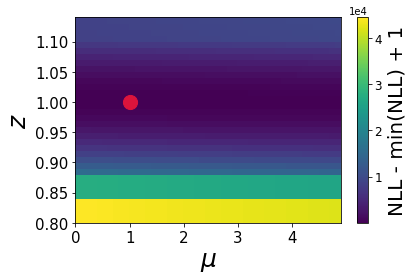

In [70]:
plot2dNLL(nll2D=nll2D_awe_nom, dataName="Nominal", clfName="Awe")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Awe", "Nominal",))
plt.show()

In [71]:
nll1D_awe_nom = nll2D_awe_nom.min(axis=1)

In [72]:
if not loadAndPlot:
    hist_obs_awe2D_systUp = createHistObsAwe(X=X_syst_test_systUp[systUpEvents], 
                                             Y_true=Y_syst_test_systUp[systUpEvents], mu=mu_test,
                            weights=weights_test_systUp[systUpEvents])
    hist_obs_awe2D_systDown = createHistObsAwe(X=X_syst_test_systDown[systDownEvents], 
                                            Y_true=Y_syst_test_systDown[systDownEvents], mu=mu_test,   
                            weights=weights_test_systDown[systDownEvents])

In [ ]:
hist_obs_awe2D_systUp = np.load("HiggsModels/hist_obs_awe2D_systUp.npy")
hist_obs_awe2D_systDown = np.load("HiggsModels/hist_obs_awe2D_systDown.npy")

In [73]:
nll2D_awe_systUp = computeNLL2D_aware(obs2D=hist_obs_awe2D_systUp, sH2d=sig_hists_awe, bH2d=back_hists_awe)
nll2D_awe_systDown = computeNLL2D_aware(obs2D=hist_obs_awe2D_systDown, sH2d=sig_hists_awe, bH2d=back_hists_awe)

Min at mu,z:  1.0 1.1
Min at mu,z:  1.0 0.8


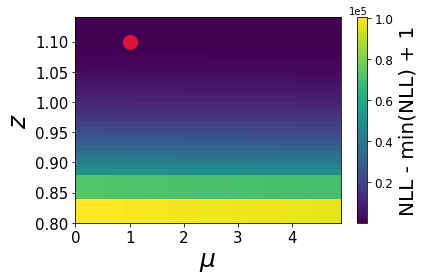

In [74]:
plot2dNLL(nll2D=nll2D_awe_systUp, dataName="SystUp", clfName="Awe")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Awe", "SystUp",))
plt.show()

In [75]:
nll1D_awe_systUp = nll2D_awe_systUp.min(axis=1)
nll1D_awe_systDown = nll2D_awe_systDown.min(axis=1)

# Invariant Model

In [76]:
if not loadAndPlot:
    sig_hists_inv, back_hists_inv = buildTemplates(model=inv_model, clfName="Invariant")

Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.8.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.84.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.88.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.89.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.9.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.91.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.92.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.93.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.94.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.95.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.96.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.97.h5
Loading file:  /data1/users/aishik/systcovariant_data/HiggsML_TES_0.98.h5
Loading file:  /data1/users/aishik/systc

In [77]:
if not loadAndPlot:
    hist_obs_inv, bin_array = createHistObs(X=X_syst_test_nominal[nominalEvents],
                                            Y_true=Y_syst_test_nominal[nominalEvents],
                                            mu=mu_test,
                                            weights=weights_test_nominal[nominalEvents], 
              model=inv_model)

In [ ]:
if not loadAndPlot:
    np.save("HiggsModels/InvSignalTemplates.npy", sig_hists_inv)
    np.save("HiggsModels/InvBackgroundTemplates.npy", back_hists_inv)
    np.save("HiggsModels/hist_obs_Inv.npy", hist_obs_inv)

In [ ]:
sig_hists_inv = np.load("HiggsModels/InvSignalTemplates.npy", )
back_hists_inv = np.load("HiggsModels/InvBackgroundTemplates.npy", )
hist_obs_inv = np.load("HiggsModels/hist_obs_Inv.npy", )

In [78]:
nll2D_inv_nom = computeNLL2D(obs1D=hist_obs_inv, sH2d=sig_hists_inv, bH2d=back_hists_inv)

Min at mu,z:  1.0 1.0


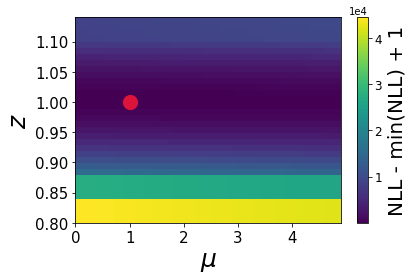

In [79]:
plot2dNLL(nll2D=nll2D_inv_nom, dataName="Nominal", clfName="Inv")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Inv", "Nominal",))
plt.show()

In [80]:
nll1D_inv_nom = nll2D_inv_nom.min(axis=1)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


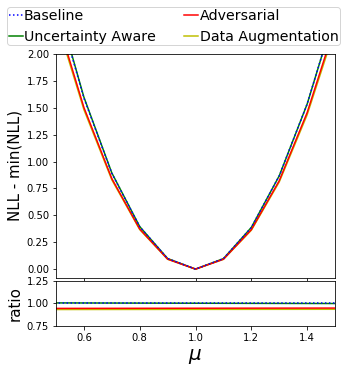

In [81]:
if mu_test==1:
    xlim = [0.5,1.5] # mu=1 study
elif mu_test==2:
    xlim = [1.5,2.5] # mu=2 study
else:
    print("Unexpected mu value")
plotNLLCurves(x=mu_values, 
              y_list=[nll1D_aug_nom-nll1D_aug_nom.min(), nll1D_awe_nom-nll1D_awe_nom.min(), 
                      nll1D_inv_nom-nll1D_inv_nom.min(), nll1D_clf_nom-nll1D_clf_nom.min()],
                label_list=["Data Augmentation", "Uncertainty Aware", "Adversarial","Baseline", ], 
                color_list=[augCol, aweCol, invCol,clfCol,], 
                linestyle_list=["solid", "solid", "solid", "dotted", ], 
              testDataLabel = "Nominal", ylimRatio=[0.75, 1.25], xlim=xlim,
              legendOrder=[3,1,2,0])
#plt.savefig(plotDir + "NLL_all_on_nominal.pdf", bbox_inches='tight',pad_inches = 0)
plt.show()

In [82]:
if not loadAndPlot:
    hist_obs_inv_systUp, bin_array = createHistObs(X=X_syst_test_systUp[systUpEvents],
                                                   Y_true=Y_syst_test_systUp[systUpEvents],
                                                   mu=mu_test,
                                                   weights=weights_test_systUp[systUpEvents], 
              model=inv_model)
    hist_obs_inv_systDown, bin_array = createHistObs(X=X_syst_test_systDown[systDownEvents],
                                                     Y_true=Y_syst_test_systDown[systDownEvents],
                                                     mu=mu_test,
                                                      weights=weights_test_systDown[systDownEvents], 
              model=inv_model)

In [ ]:
hist_obs_inv_systUp = np.load("HiggsModels/hist_obs_inv_systUp.npy", )
hist_obs_inv_systDown = np.load("HiggsModels/hist_obs_inv_systDown.npy", )

In [83]:
nll2D_inv_systUp = computeNLL2D(obs1D=hist_obs_inv_systUp, sH2d=sig_hists_inv, bH2d=back_hists_inv)
nll2D_inv_systDown = computeNLL2D(obs1D=hist_obs_inv_systDown, sH2d=sig_hists_inv, bH2d=back_hists_inv)

nll1D_inv_systUp = nll2D_inv_systUp.min(axis=1)
nll1D_inv_systDown = nll2D_inv_systDown.min(axis=1)

Min at mu,z:  1.0 1.1
Min at mu,z:  1.0 0.8


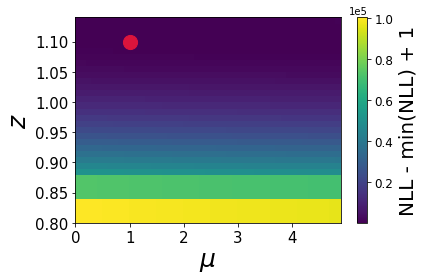

In [84]:
plot2dNLL(nll2D=nll2D_inv_systUp, dataName="SystUp", clfName="Inv") 
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Inv", "SystUp",))
plt.show()

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


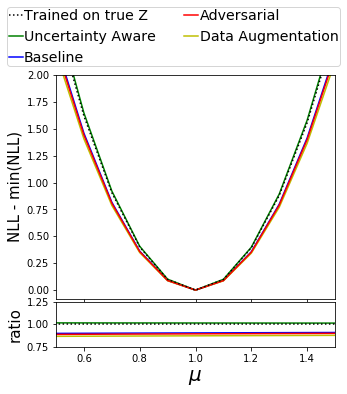

In [85]:
plotNLLCurves(x=mu_values, 
              y_list=[nll1D_clf_systUp-nll1D_clf_systUp.min(), nll1D_aug_systUp-nll1D_aug_systUp.min(),
                      nll1D_awe_systUp-nll1D_awe_systUp.min(), nll1D_inv_systUp-nll1D_inv_systUp.min(),
                      nll1D_up_systUp-nll1D_up_systUp.min()],
                label_list=[ "Baseline", "Data Augmentation", "Uncertainty Aware", "Adversarial", "Trained on true Z" ], 
                color_list=[clfCol, augCol, aweCol,  invCol, clfNomCol], 
                linestyle_list=["solid", "solid", "solid", "solid", "dotted"], 
              testDataLabel = "systUp", ylimRatio=[0.75, 1.25], xlim=xlim,
             legendOrder=[4,2,0,3,1]) # legend order tells you which plot should come first, then next, next, ...
#plt.savefig(plotDir + "NLL_all_on_systUp.pdf", bbox_inches='tight',pad_inches = 0)
plt.show()

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


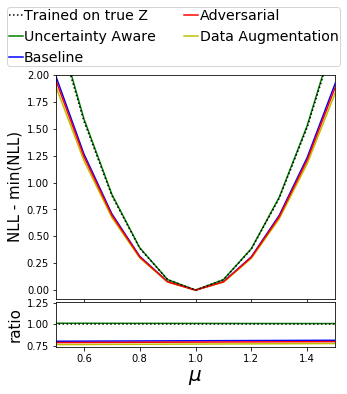

In [86]:
plotNLLCurves(x=mu_values, 
              y_list=[nll1D_clf_systDown-nll1D_clf_systDown.min(), nll1D_aug_systDown-nll1D_aug_systDown.min(),
                      nll1D_awe_systDown-nll1D_awe_systDown.min(), nll1D_inv_systDown-nll1D_inv_systDown.min(),
                      nll1D_down_systDown-nll1D_down_systDown.min()],
                label_list=[ "Baseline", "Data Augmentation", "Uncertainty Aware", "Adversarial", "Trained on true Z" ],
                color_list=[ clfCol, augCol, aweCol, invCol, clfNomCol,], 
                linestyle_list=["solid", "solid", "solid", "solid", "dotted" ],
              testDataLabel = "systDown", ylimRatio=[0.74, 1.26], xlim=xlim,
             legendOrder=[4,2,0,3,1])
#plt.savefig(plotDir + "NLL_all_on_systDown.pdf", bbox_inches='tight',pad_inches = 0)
plt.show()